# Report

---

In this notebook, we will see an implementation for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

## Implementation specs

### Summary

We implement a continuous machine learning algorithm to solve the multi-agent version of the Reacher problem -- controlling mechanical arms to reach a specific positions in space, with state variables describing the arm physical state and action variables controlling the joints.

To do so, we implement a [Proximal Policy Optimization (PPO) algorithm](https://openai.com/blog/openai-baselines-ppo/), 
with a partially shared network for the actor and critic estimators, with a stochastic policy, for any number of identical
agents.  We also use [Generalized Advantage Estimation (GAE)](https://arxiv.org/abs/1506.02438) to interpolate trajectory returns for various lengths.  PPO has some fame for being simple to implement, stable, and easy to tune (for a deep RL algorithm), despite being as new as 2017.

This implementation is built after reviewing the implementation of [Shangtong Zhang's 
Deep RL](https://github.com/ShangtongZhang/DeepRL) PPO continuous algorithm in PyTorch -- similar code structure,
but with different hyperparameters, loss function weights, and creating an object-oriented representation
for the agent itself outside of the training code.

### Details

#### Policy and values

A shared neural network with two heads is responsible for computing a stochastic policy (actor) and value estimation (critic).

A basis body of 2 fully connected layers, with rectified linear units, extracts 'features' that are used by the actor
and the critic networks:

     s -> Linear(|s|, 512) -> ReLU() -> Linear(512, 512) -> ReLU() -> F
     
The features are then processed by two distinct networks to provide policy and value estimates:

    F -> Linear(512, 512) -> ReLU() -> Linear(512, |A|) -> Tanh() -> [\mu(s, a_i) for a_i in A]
    F -> Linear(512, 512) -> ReLU() -> Linear(512, 1) -> V(s)
    
The policy generates actions stochastically according to a normal distribution, with standard deviation $\sigma$ also maintained as model parameters:

$$ \pi (s, a_i) \sim \mathcal{N}(\mu(s, a_i), \sigma^2) $$

The log probability of the distribution is also computed from this policy.

This logic is implemented under class `GaussianActorCriticNet` under `model.py`.


#### Trajectory and batch extraction

We maintain trajectories of `trajectory_length` = 1000 episodes over all 20 agents simultaneously, storing experience tuples (s, a, log_prob, v, r, non_terminal):

| variable      | description                                                  |
|---------------|--------------------------------------------------------------|
| s             | Initial state for the experience                             |
| a             | Action chosen by the policy                                  |
| log_prob      | Log probability for the action to be generated by the policy |
| v             | Value for the state computed by the critic                   |
| r             | Reward obtained from the action                              |
| non_terminal  | Whether this state is non-terminal (1 - done)                |

When enough tuples are collected, they are rolled back from end to start, associating and advantage function and a cumulative backward reward for each experience:

    returns := rewards + gamma * non_terminals * returns
    td_error := rewards + gamma * non_terminals * next_values - values
    advantages := advantages * gae_lambda * gamma * non_terminals + td_error
    
Finally, for a number of `optimization_steps`, minibatches of size `batch_size` are collected (for each of the agents) and used to train the network according to the combined loss function.

#### Loss functions

For the policy loss function, we use the clipped version of the PPO policy loss, $L_{CLIP}(\theta)$, computed over the sampled batches:

$$ L(\theta) = \prod_{\tau \in \mathcal{T}} \frac{\pi_{new}(s, a)}{\pi_{old}(s, a)} A(s, a) = \exp \left( \sum_{\tau \in \mathcal{T}} \log \pi_{new}(s,a) - \sum_{\tau \in \mathcal{T}} \log \pi_{old}(s, a) \right) A(s, a)$$

$$ L_{CLIP}(\theta) = \min \left( \frac{L(\theta)}{A(s, a)}, \textrm{clip}\left(\frac{L(\theta)}{A(s, a)}, 1 - \epsilon, 1 + \epsilon \right)A(s, a) \right) $$

For the value loss function, we use mean square error between critic function output and rolled back rewards:

$$ L_{\textrm{value}}(\theta) = \sum_s \left(V(s) - R(s) \right)^2 $$

Finally, we apply a penalty to the entropy of the distribution -- encouraging $\sigma$ parameters to become smaller / the policy to become less stochastic:

$$ E(\theta) = \frac{1}{2} \log (2 \pi e \sigma^2) $$

The loss function used during optimization is a (weighted) sum of the loss components above:

$$ L_{\textrm{combined}}(\theta) = L_{CLIP}(\theta) + w_v L_{\textrm{value}}(\theta) + w_e E(\theta) $$

The loss functions are implemented on the agent itself, in `ppo_agent.py`.


#### Hyperparameters

Agent hyperparameters may be passed as constructor arguments to `MultiAgent`.  The default values, used in this workbook, are:

| parameter                | value      | description                                                                   |
|--------------------------|------------|-------------------------------------------------------------------------------|
| shared_network_units     | [512, 512] | Network topology for shared network between actor and critic functions        | 
| actor_network_units      | [512]      | Network topology for actor network function                                   |
| critic_network_units     | [512]      | Network topology for critic network function                                  |
| optimizer_learning_rate  | 5e-4       | Initial learning rate for Adam optimizer                                      |
| optimizer_epsilon        | 1e-5       | Tolerance parameter for Adam optimizer                                        |
| trajectory_length        | 1000       | Number of steps cached before trajectory rollback                             |
| gamma                    | 0.99       | Discount rate for future rewards                                              |
| gae_lambda               | 0.9        | Interpolating parameter for GAE                                               |
| optimization_steps       | 16         | Number of optimization steps to perform after trajectory rollback             |
| batch_size               | 256        | Number of N-agent experiences to collect for a single optimization step       |
| gradient_clip            | 0.25       | Clipping parameter for gradient descent during optimization                   |
| ppo_ratio_clip_epsilon   | 0.2        | Clipping parameter for the policy loss function                               |
| entropy_penalty_weight   | 0.01       | Weight applied to entropy penalty on total loss function                      |
| value_loss_weight        | 1.0        | Weifht applied to value loss on total loss function                           |

Training hyperparameters are passed on the training function itself, `train_multiagent`, defined below.  The default values are:

| parameter                     | value     | description                                           |
|-------------------------------|-----------|-------------------------------------------------------|
| n_episodes                    | 300       | Maximum number of training episodes                   |
| max_t                         | 1000      | Maximum number of steps per episode                   |
| solved_score                  | 30        | Average score required to consider problem solved     |

## Execution

Import required system packages: 

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name='Reacher_Windows_x86_64/Reacher.exe')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Let's get the state and action dimensions, and initialize our agent:

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

In [4]:
# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


In [5]:
# Initialize agent

from ppo_agent import MultiAgent

multiagent = MultiAgent(
    state_size=state_size, 
    action_size=action_size,
    shared_network_units=[512, 512],
    actor_network_units=[512],
    critic_network_units=[512],
    value_loss_weight=1.0,
    gradient_clip=0.25,
    ppo_ratio_clip_epsilon=0.2,
    trajectory_length=1000,
    gamma=0.99,
    gae_lambda=0.9,
    optimization_steps=16,
    batch_size=256,
    entropy_penalty_weight=0.01,
    optimizer_learning_rate=5e-4
)

Next, we define interactions with agent:

In [6]:
from collections import deque

def train_multiagent(
    env, 
    multiagent, 
    n_episodes=300, 
    max_t=1000, 
    display_every=10,
    solved_score=30, 
    save_filename=None
):
    scores = []
    scores_window = deque(maxlen=100)
    
    for i_episode in range(1, n_episodes + 1):    
        env_info = env.reset(train_mode=True)[brain_name]
        
        n_actors = len(env_info.vector_observations)
        score = np.zeros(n_actors)
        episode_length_list = []
        episode_counter = np.zeros(n_actors)
        
        for t in range(1, max_t+1):
            states = env_info.vector_observations
            if np.isnan(states).any():
                print('\nNaN found in states')
                return scores
            
            actions = multiagent.act(states)
            
            if np.isnan(actions).any():
                print('\nNaN found in actions')
                return scores
            
            env_info = env.step(actions)[brain_name]
            
            next_states = env_info.vector_observations
            rewards = np.array(env_info.rewards)
            
            if np.isnan(rewards).any():
                print('\nNaN found in rewards')
                rewards = np.where(np.isnan(rewards), -5, rewards)
            
            dones = env_info.local_done
            
            multiagent.step(
                states, 
                actions, 
                rewards,
                next_states, 
                dones
            )
            
            score += np.array(rewards)
            score = np.where(dones, 0, score)

        mean_score = score.mean()
        scores_window.append(mean_score)       # save most recent score
        scores.append(mean_score)              # save most recent score
        
        print('\rEpisode {}\tAverage score: {:.2f}'.format(
            i_episode, np.mean(scores_window)
        ), end="")
        if i_episode % display_every == 0:
            print('\rEpisode {}\tAverage score: {:.2f}'.format(
                i_episode, np.mean(scores_window)
            ))
            
        if np.mean(scores_window) >= solved_score:
            print('\nEnvironment solved in {:d} episodes!\tAverage score: {:.2f}'.format(
                np.maximum(i_episode-100, 0), np.mean(scores_window))
             )
            if save_filename is not None:
                multiagent.save(save_filename)
            break
    
    return scores

Train the agent to required scores:

Episode 10	Average score: 0.62
Episode 20	Average score: 1.21
Episode 30	Average score: 1.98
Episode 40	Average score: 2.70
Episode 50	Average score: 3.45
Episode 60	Average score: 4.43
Episode 70	Average score: 6.01
Episode 80	Average score: 8.03
Episode 90	Average score: 10.21
Episode 100	Average score: 12.57
Episode 110	Average score: 16.17
Episode 120	Average score: 19.73
Episode 130	Average score: 23.13
Episode 140	Average score: 26.39
Episode 150	Average score: 29.49
Episode 152	Average score: 30.08
Environment solved in 52 episodes!	Average score: 30.08


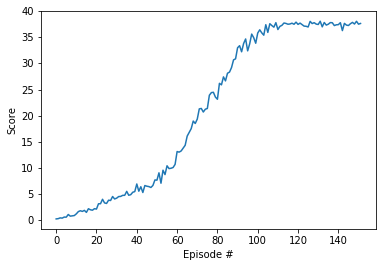

In [7]:
scores = train_multiagent(env, multiagent, solved_score=30, save_filename="checkpoint-reacher-30.pth")

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

We can now watch our trained agent in action:

In [12]:
# load the weights from file
multiagent.load('checkpoint-reacher-30.pth')

# Run through once with loaded model
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = multiagent.act(states)                   # get actions from model (for each agent)
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 37.71349915703759


When finished, you can close the environment.

In [13]:
env.close()

# Ideas for future work

* Experiment with new training environments, implement new training environments
* Implement solutions with other algorithms (A2C, ACER, DDPG) and compare performance
* Experiment with larger network architectures for faster learning and/or larger score before stabilization
* Review literature for PPO extensions
* Investigate applicability of meta-learning algorithms to the policy, value, or rewards in the PPO setting, such as:
    - [Evolved Policy Gradients](https://arxiv.org/pdf/1802.04821.pdf)
    - [Self-Regulated Learning](http://mrl.snu.ac.kr/research/ProjectAerobatics/Aerobatics.htm)